# Multifractal spectrum example
### This notebook shows how to generate a random walk (persistent, antipersistent, or Brownian), and analyze it using the [CWTMM](https://en.wikipedia.org/wiki/Continuous_wavelet_transform) technique to compute a [multifractal](https://en.wikipedia.org/wiki/Multifractal_system) [spectrum](https://en.wikipedia.org/wiki/Singularity_spectrum).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcol
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys
import warnings

warnings.filterwarnings("ignore", module="matplotlib")

# set seed --> same random numbers generated each time
np.random.seed(22)

# add the code we need to the sys.path
sys.path.append('../..')
from pycwtmm import modulus_maxima as mm
from pycwtmm import plotting as cpl
from pycwtmm import fractional_brownian_motion as fbm

## Generate a random walk

In [2]:
num_steps = 500
hurst_exponent = 0.5
# example exponents:
# 0.5 = brownian motion
# 0.1 = antipersistent
# 0.9 = persistent

steps = fbm.make_timeseries(num_steps, hurst_exponent)

## Plot the random walk

[Text(0.5, 0, 'time'),
 Text(0, 0.5, 'amplitude'),
 Text(0.5, 1.0, 'random walk ($H = 0.5$)')]

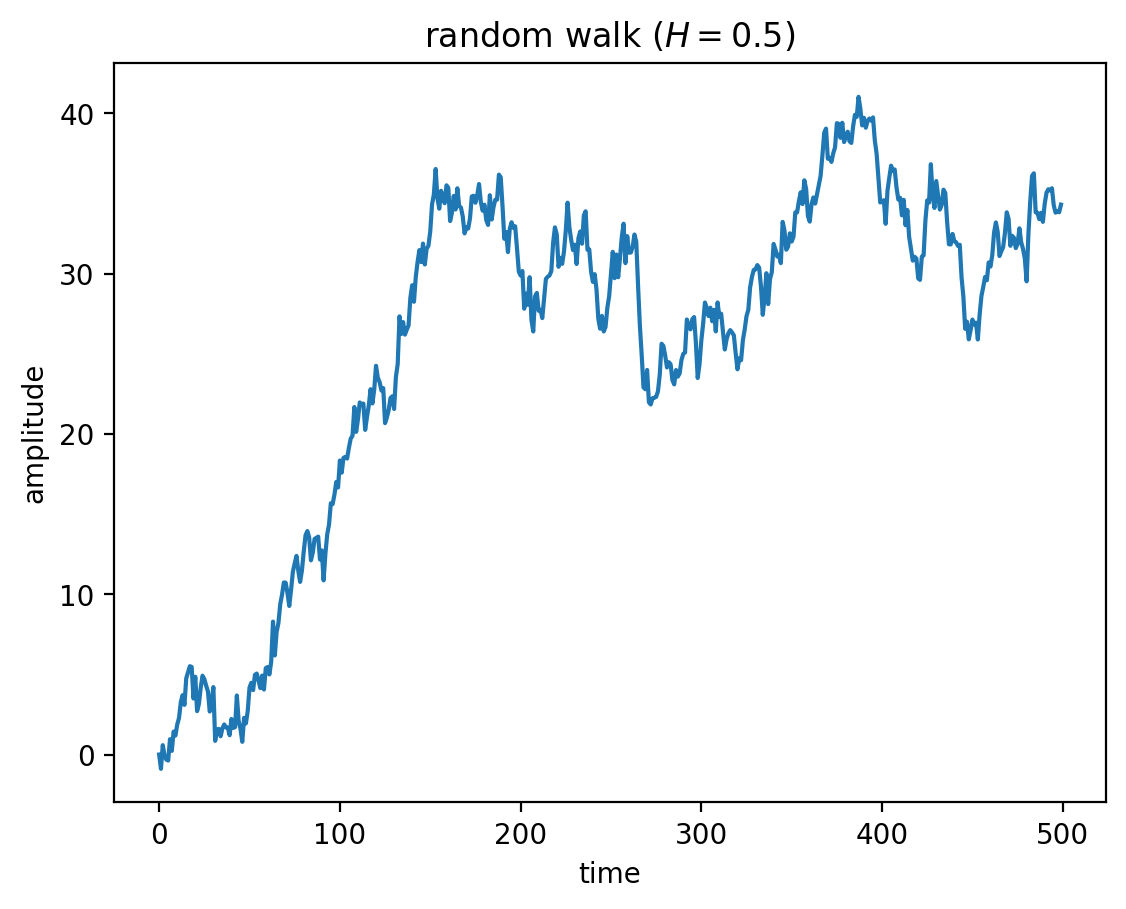

In [3]:
fig, ax = plt.subplots()
ax.plot(np.arange(steps.size), steps)
ax.set(xlabel='time', ylabel='amplitude', title=f'random walk ($H = {hurst_exponent}$)')

## Apply the CWTMM technique

In [4]:
# Wavelet widths up to a maximum of (num time steps) / 2
# logarithmically spaced
num_widths = num_steps * 2
wavelet_widths = 2 ** np.linspace(np.log2(2), np.log2(num_steps) / 2, num=num_widths)

time = np.arange(steps.size)

wmz = mm.Wtmmizer(
    time_mids=time,
    raw_signal=steps,
    scales=wavelet_widths
)

## Plot the wavelet transform after connecting modulus maxima

In [5]:
# See the function definition for more options
wmz.connect_wavelet_modulus_maxima()

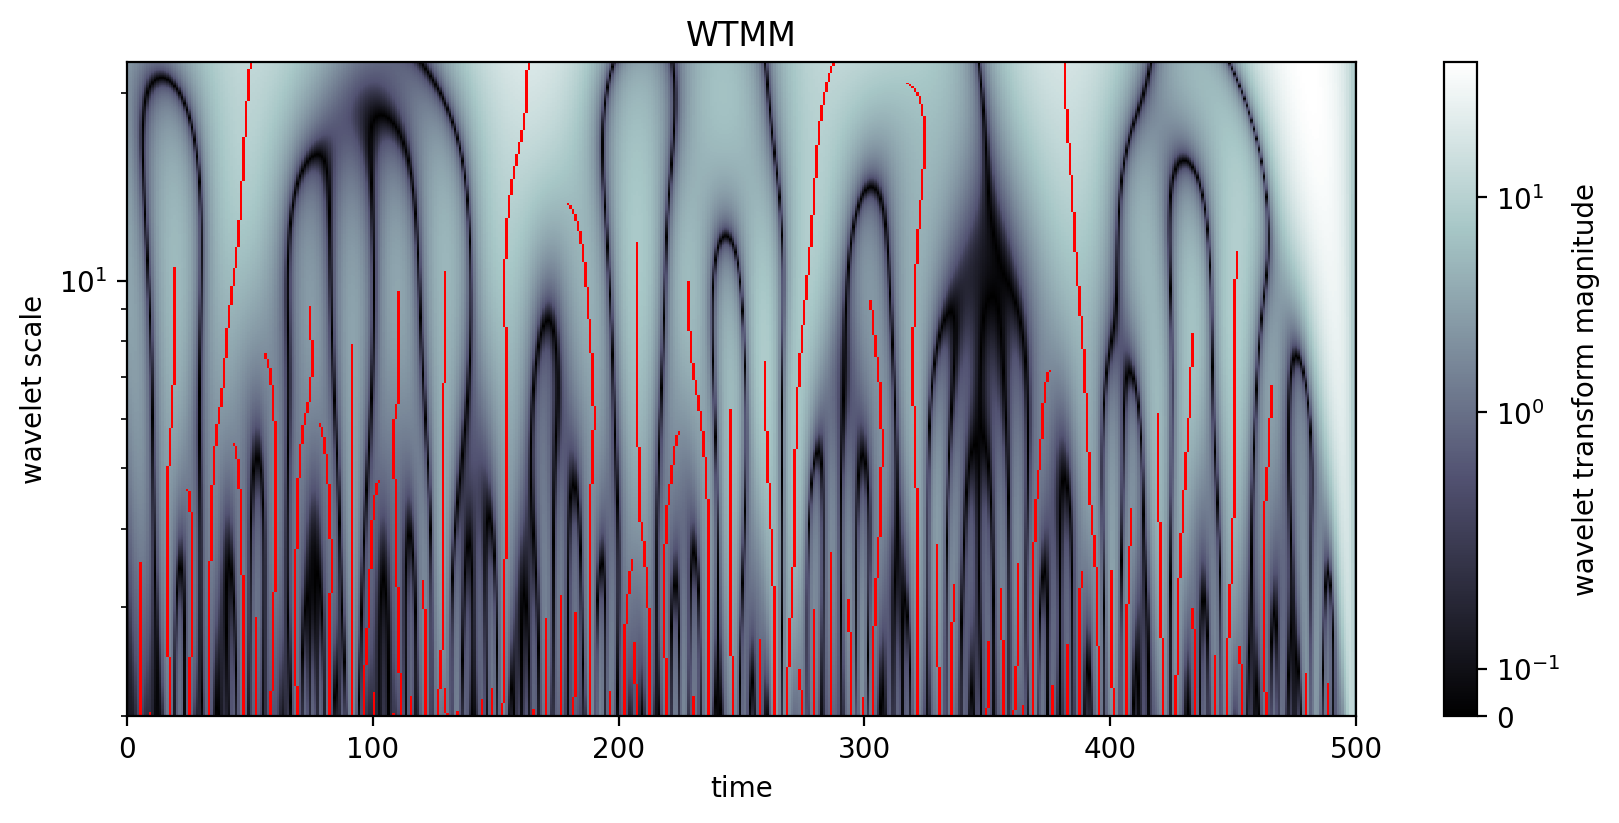

In [6]:
fig, ax = plt.subplots(figsize=(8, 4), layout='constrained')

local_maxima_mask = wmz.maxima_connected()
cwt_magnitude = wmz.modulus
norm = mcol.SymLogNorm(linthresh=0.5, vmin=0, vmax=cwt_magnitude.max())

cbar = cpl.plot_cwt_modulus_maxima(
    wmz.time_mids,
    wmz.scales,
    cwt=wmz.cwt_matrix,
    ax=ax,
    fig=fig,
    mm=local_maxima_mask,
    mm_color='red',
    cmap='bone',
    norm=norm
)

cbar.set_label('wavelet transform magnitude')
ax.set(yscale='log', xlabel='time', ylabel='wavelet scale', title='WTMM')
plt.show()

## Compute the multifractal exponents

In [7]:
# Moments at which you want to compute the multifractal spectrum
moments = np.linspace(-8, 8, num=50)

wmz.compute_multifractal(moments)

## Plot the multifractal spectra

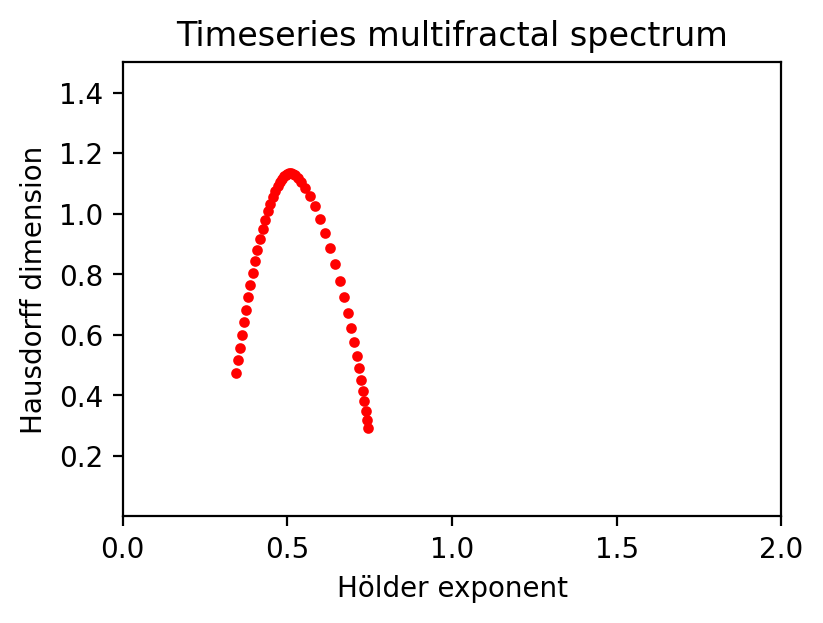

In [8]:
fig, ax = plt.subplots(figsize=(4, 3), layout='constrained')

cpl.plot_multifractal(
    hoelder=wmz.multifractals.hoelder.true,
    hausdorff=wmz.multifractals.hausdorff.true,
    ax=ax
)

ax.set(
    xlabel='Hölder exponent',
    ylabel='Hausdorff dimension',
    title='Timeseries multifractal spectrum',
    xlim=(0, 2),
    ylim=(1e-5, 1.5)
)

plt.show()

## Try changing the Hurst exponent above.
## The multifractal spectrum should move to the right (larger exponent) or left (smaller exponent)